# Import and global values

In [253]:
import pandas as pd
import numpy as np

import apimoex
import requests

import matplotlib.pyplot as plt
from numpy.typing import ArrayLike

In [254]:
stock_names = ['RASP', 'GAZP', 'DSKY', 'SBER', 'KMAZ', 'RUAL']
start_date = '2023-01-01'
end_date = '2023-05-05'

# Functions

In [255]:
def load_data(stock_names=stock_names, start=start_date, end=end_date):
    df = pd.DataFrame()
    with requests.Session() as session:
        for stock in stock_names:
            data = apimoex.get_board_history(session, stock, start=start, end=end, columns=['CLOSE', 'TRADEDATE'])
            df_stock = pd.DataFrame(data)
            df_stock.set_index('TRADEDATE', inplace=True)
            df[stock] = df_stock
    return df


def prepare_r(df_stocks):
    return (df_stocks.shift(-1) / df_stocks).dropna() 

In [256]:
def get_grad(r, x):
    return -r / np.dot(r, x)


def _unsafe_simplex_projection(s: ArrayLike, norm_constraint: float) -> ArrayLike:
    """Находит проекцию на симплекс."""
    u = np.sort(s)[::-1]
    cssv = np.cumsum(u)
    rho = np.nonzero(u * np.arange(1, len(u) + 1) > (cssv - norm_constraint))[0][-1]
    theta = (cssv[rho] - norm_constraint) / (rho + 1.0)
    return np.maximum(s - theta, 0)


def simplex_projection(s: ArrayLike):
    """Возвращает проекцию на единичный симплекс."""
    return s if np.sum(s) == 1 else _unsafe_simplex_projection(s, 1.0)

In [257]:
def get_this_score(r, x):
    return -np.log(np.dot(r, x))

def get_max_score(r, x):
    return -np.log(np.max(r))

def get_score(r, x):
    return get_this_score(r, x) -  get_max_score(r, x)

def descent_step(this_state, r, alpha):
    x = this_state
    # print("grad of r and x - ", get_grad(r, x))
    new_x = simplex_projection(x - alpha * get_grad(r, x))
    # print('new x - ', new_x)
    return new_x


def descent(begin_state, df_r,lr_scheduler=lambda i: 0.1):
    x = begin_state

    n = df_r.shape[0]

    scores = []
    profit = []
    vectors = [x]

    profit = 1.0
    profit_vec = [profit]

    for i in range(n):
        r = df_r.iloc[i].values
        # print(x)
        score = get_score(r, x)
        scores.append(score)
        alpha = lr_scheduler(i)
        profit *= (r * x).sum()
        profit_vec.append(profit)
        new_x = descent_step(x, r, alpha)
        x = new_x
        vectors.append(new_x)
        # print('r and x before next iteration - ', r, x)

    return (vectors, scores, profit_vec)
    

# Data load

In [258]:
data = load_data()
r = prepare_r(data)

#Visualisation

<AxesSubplot: xlabel='TRADEDATE'>

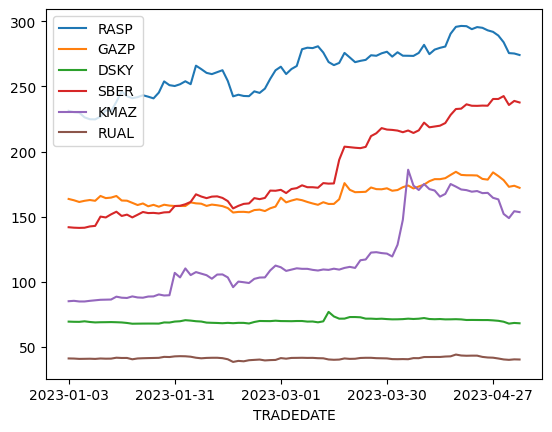

In [259]:
data.plot()

In [260]:
data

,RASP,GAZP,DSKY,SBER,KMAZ,RUAL
TRADEDATE,,,,,,
2023-01-03,231.25,163.52,69.22,141.78,84.9,40.900
2023-01-04,230.25,162.51,69.08,141.43,85.2,40.820
2023-01-05,229.85,161.20,69.04,141.27,84.7,40.565
2023-01-06,226.25,162.10,69.46,141.40,84.7,40.620
2023-01-09,224.80,162.71,68.94,142.40,85.2,40.695
...,...,...,...,...,...,...
2023-04-28,289.15,181.13,69.84,240.38,163.2,40.865
2023-05-02,284.00,177.97,69.14,242.62,152.0,40.140
2023-05-03,275.65,172.87,67.68,235.77,148.8,39.825


#Safe method (no more than 50% of portfolio in one company)

In [261]:
safe_alpha_array = np.logspace(1, 10, 1000, base=4) * 0.0001

In [262]:
safe_best_alpha = -1

for i in safe_alpha_array:
    vectors, scores, profit = descent(np.ones(r.shape[1]) * (1/r.shape[1]) , r, lr_scheduler=lambda x: i)
    if np.max(vectors) > 0.5:
      best_alpha = i
      break

In [263]:
safe_best_alpha

-1

In [264]:
safe_profit_to_date = pd.DataFrame(index=data.index, columns=["profit"])
safe_profit_to_date['profit'] = profit

<AxesSubplot: xlabel='TRADEDATE'>

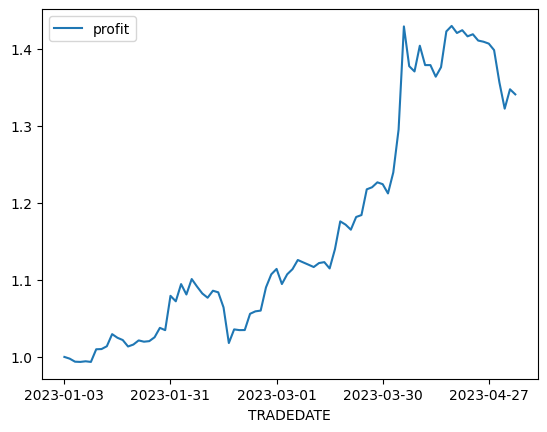

In [265]:
safe_profit_to_date.plot()

In [266]:
#final profit
safe_profit_to_date['profit'][-1]

1.340601321308225

#Unsafe method

In [267]:
unsafe_alpha_array = np.logspace(1, 10, 1000, base=5.1) * 0.0001

In [268]:
unsafe_max_profit = [0]
unsafe_best_alpha = -1

for i in unsafe_alpha_array:
    vectors, scores, profit = descent(np.ones(r.shape[1]) * (1/r.shape[1]) , r, lr_scheduler=lambda x: i)
    if profit[-1] > max_profit[-1]:
      max_profit = profit
      best_alpha = i

In [269]:
unsafe_best_alpha

-1

In [270]:
unsafe_profit_to_date = pd.DataFrame(index=data.index, columns=["profit"])
unsafe_profit_to_date['profit'] = profit

<AxesSubplot: xlabel='TRADEDATE'>

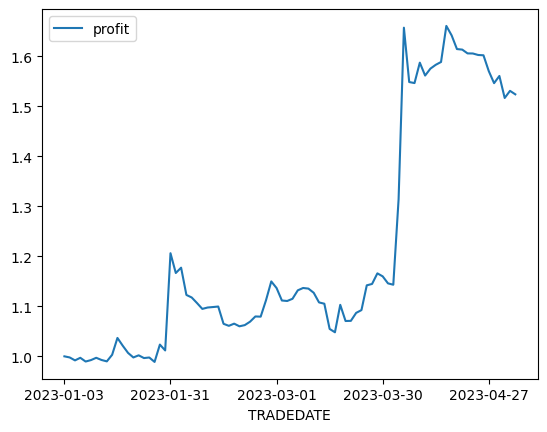

In [271]:
unsafe_profit_to_date.plot()

In [272]:
#final profit
unsafe_profit_to_date['profit'][-1]

1.5241055106801626